# Выбор локации для скважины

Вы работаете в добывающей компании «ГлавРосГосНефть». Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

<b><u>Цель:</u></b> Нужно решить, где бурить новую скважину.

<b><u>Задача:</u></b>
1. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
2. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

 <b><u>Шаги для выбора локации:</u></b>

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
# !pip install python-pip -U -q
# !pip install numba==0.59.1 -q
# !pip install numpy==1.23.1 -q
# !pip install scipy -U -q


# !pip install matplotlib -U -q
# !pip install seaborn -U -q
# !pip install phik -U -q
# !pip install shap -U -q

# !pip install pandas==2.2.2 -q
# !pip install jinja2==3.1.2 -q
# !pip install scikit-learn==1.4 -q

## Загрузка и подготовка данных

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import RandomState

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import Pipeline

state = RandomState(12345)

In [3]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Oil_project\\"
project_path_02 = "/datasets/"

In [4]:
if os.path.exists(project_path_01):
    data_01 = pd.read_csv(project_path_01 + 'geo_data_0.csv')
    data_02 = pd.read_csv(project_path_01 + 'geo_data_1.csv')
    data_03 = pd.read_csv(project_path_01 + 'geo_data_2.csv')
elif os.path.exists(project_path_02):
    data_01 = pd.read_csv(project_path_02 + 'geo_data_0.csv')
    data_02 = pd.read_csv(project_path_02 + 'geo_data_1.csv')
    data_03 = pd.read_csv(project_path_02 + 'geo_data_2.csv')    
else:
    print("Smth wrong")

In [5]:
def df_info (df):
        print(df.info())
        return df.head()

In [6]:
df_info(data_01)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
df_info(data_02)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
df_info(data_03)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Предобработка

оценим
- полные дубли
- пропуски
- 0 данные

In [9]:
def output_info(df):
    output = []
    for col in df.columns:
        nul = df[col].isna().sum()
        non_nul = len(df) - nul
        n_uniq = df[col].nunique()
        col_type = str(df[col].dtype)
        output.append([col, nul, non_nul, n_uniq, col_type])
    output = pd.DataFrame(output)
    output.columns = [
        'col_names', 'non-null_values','null_values', 'unique_amount', 'dtype']
    return output

#### data_01

In [10]:
data_01.duplicated().sum()

0

In [11]:
output_info(data_01)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,0,100000,99990,object
1,f0,0,100000,100000,float64
2,f1,0,100000,100000,float64
3,f2,0,100000,100000,float64
4,product,0,100000,100000,float64


удалим дубли по 'id'

In [12]:
data_01.drop_duplicates(subset=['id'], keep='first', inplace=True)
data_01.shape

(99990, 5)

In [13]:
data_01.eq(0).any(axis=1).sum()

1

данные с 0 запасом удаляеми

In [14]:
# data_01.drop(data_01[data_01.eq(0).any(axis=1)].index, inplace=True)
# data_01.shape

In [15]:
data_01.set_index('id', inplace=True)
data_01.shape

(99990, 4)

#### data_02

In [16]:
data_02.duplicated().sum()

0

In [17]:
output_info(data_02)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,0,100000,99996,object
1,f0,0,100000,100000,float64
2,f1,0,100000,100000,float64
3,f2,0,100000,100000,float64
4,product,0,100000,12,float64


In [18]:
data_02.drop_duplicates(subset=['id'], keep='first', inplace=True)
data_02.shape

(99996, 5)

оценим 12 уникальных значений столбца product

In [19]:
data_02['product'].value_counts()[data_02['product'].value_counts() > 1]

product
53.906522     8472
26.953261     8468
84.038886     8430
57.085625     8389
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8303
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8200
Name: count, dtype: int64

In [20]:
f"{data_02['product'].eq(0).sum()/len(data_02):.0%}"

'8%'

Придется пожертвовать 8% данных, т.к. заполнение нулевых значений средним или модой приведет к серьезным искажениям данных

In [21]:
# data_02.drop(data_02[data_02.eq(0).any(axis=1)].index, inplace=True)
# data_02.shape

In [22]:
data_02.set_index('id', inplace=True)
data_02.shape

(99996, 4)

#### data_03

In [23]:
data_03.duplicated().sum()

0

In [24]:
output_info(data_03)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,0,100000,99996,object
1,f0,0,100000,100000,float64
2,f1,0,100000,100000,float64
3,f2,0,100000,100000,float64
4,product,0,100000,100000,float64


In [25]:
data_03.drop_duplicates(subset=['id'], keep='first', inplace=True)
data_03.shape

(99996, 5)

In [26]:
data_03.eq(0).any(axis=1).sum()

1

Удаляем 0 значение

In [27]:
# data_03.drop(data_03[data_03.eq(0).any(axis=1)].index, inplace=True)
# data_03.shape

In [28]:
data_03.set_index('id', inplace=True)
data_03.shape

(99996, 4)

### Выводы загрузка и предобработка

1.	Получено три файла
    - geo_data_0.csv
    - geo_data_1.csv
    - geo_data_2.csv 
2.  Признаки
    -	id — уникальный идентификатор скважины;
    -	f0, f1, f2 — три признака точек;
    -	product — объём запасов в скважине (тыс. баррелей), целевой признак.
3. Файлы прочитаны в 3 датасета с установление столбца 'id' в качестве индекса:
    - data_01
    - data_02
    - data_03
4. data_01
    - размерность (100_000, 5)
    - все данные float
    - нет полных дублей
    - удалены дубли по столбцу 'id'
    - удалена одна строка с 0 данными в столбце 'product'
    - установим 'id' в качестве индекса
    - новая размерность (99_989, 4)
5. data_02
    - размерность (100_000, 5)
    - все данные float
    - нет полных дублей
    - удалены дубли по столбцу 'id'
    - столбец 'product' содержит всего 12 уникальных значений
    - 8235 значений (8%) столбца 'product' равны 0
    - заполнить значения модой или средним не представляется возможным
    - удалены 8235 значений с 0 данными в столбце 'product'
    - установим 'id' в качестве индекса
    - новая размерность (91_761, 4)
6. data_03
    - размерность (100_000, 5)
    - все данные float
    - нет полных дублей
    - удалены дубли по столбцу 'id'
    - удалена одна строка с 0 данными в столбце 'product'
    - установим 'id' в качестве индекса
    - новая размерность (99_994, 4)

## Обучение и проверка модели

- разделим данные на обучающую и валидационную выборки в соотношении 75:25
- обучим модель и сделаем предсказания на валидационной выборке
- оценка RMSE

In [29]:
def cv_func (df, target, label):
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42
    )
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', LinearRegression())
    ])
    pipeline.fit(X_train, y_train)
    predicts = pipeline.predict(X_valid)
    scores = root_mean_squared_error(y_valid, predicts)
    predicts = pd.DataFrame(predicts)
    predicts.index = y_valid.index
    predicts.columns = [label]
    return scores, predicts, y_valid

In [30]:
preds_region_01 = cv_func(data_01, 'product', 'region_01')
print(f'RMSE предсказаний для 1го региона: {preds_region_01[0]:.2f}')
print(f'Средний запас сырья для 1го региона: {preds_region_01[1].values.mean():.2f}')


RMSE предсказаний для 1го региона: 37.69
Средний запас сырья для 1го региона: 92.61


In [31]:
preds_region_02 = cv_func(data_02, 'product', 'region_02')
print(f'RMSE предсказаний для 2го региона: {preds_region_02[0]:.2f}')
print(f'Средний запас сырья для 2го региона: {preds_region_02[1].values.mean():.2f}')

RMSE предсказаний для 2го региона: 0.89
Средний запас сырья для 2го региона: 68.58


In [32]:
preds_region_03 = cv_func(data_03, 'product', 'region_03')
print(f'RMSE предсказаний для 3го региона: {preds_region_03[0]:.2f}')
print(f'Средний запас сырья для 3го региона: {preds_region_03[1].values.mean():.2f}')

RMSE предсказаний для 3го региона: 40.08
Средний запас сырья для 3го региона: 94.93


### Выводы. Обучение и предсказание моделей на кросс-валидации

1. подготовлена функция для предсказания объема запасов в регионе
    - разбизвка на 3 валидационных блока
    - модель Линейная регрессия
    - метрика Корень из среднеквадратичной ошибки
2. Результаты для 1-го региона
    - запас сырья 92,75 тыс. бареллей
    - RMSE: 37.66
3. Результаты для 2-го региона
    - запас сырья 75,08 тыс. бареллей
    - RMSE: 0.88
4. Результаты для 3-го региона
    - запас сырья 94,92 тыс. бареллей
    - RMSE: 40.11

## Подготовка к расчёту прибыли

- 1k баррелей = 450k рублей
- 'product' х 450k = выручка со скважины
- бюджет = себестоимость = 10_000_000k рублей
- 200 скважин x product х 450k - бюджет = 0 (точка безубыточности) 

In [33]:
BUDGET = 10000000
PRICE = 450
WELL_CHOOSEN = 500
WELL_AMOUNT = 200
product_breakeven = BUDGET / (PRICE)
prod_oil_per_well = BUDGET / (PRICE * WELL_AMOUNT)
print(f'Себестоимость работ в регионе = {product_breakeven:.0f}')
print(f'Безуботчный запас на 1 шахту = {prod_oil_per_well:.0f}')

Себестоимость работ в регионе = 22222
Безуботчный запас на 1 шахту = 111


истинный средний запас в регионах

In [34]:
oil_in_regions = pd.DataFrame(np.array([
    data_01['product'].values.mean(),
    data_02['product'].values.mean(),
    data_03['product'].values.mean(),
    prod_oil_per_well
]
).reshape((1,4)))
oil_in_regions.columns = ['region_01', 'region_02', 'region_03', 'breakeven' ]
oil_in_regions

,region_01,region_02,region_03,breakeven
0,92.499684,68.823916,94.998342,111.111111


### Выводы. Подготовка к расчету

- затраты (бюджет) на разработку 200 скважин в регионе составляют 10 млрд. рублей
- точка безубыточности расчитыватеся как:
    - 200 скважин * запас 1 скавжины * цену тысячи барралей и должна равняться 10 млрд. рублей
- запас сырья одной скважины должен быть не менее 111 тыс. барралей
- средний запас сырья в регионах меньше:
    - region_01: 92.5
    - region_02: 75.0
    - region_03: 95.0


## Расчёт прибыли и рисков 

функция расчета прибыли:
- отбор 500 скважин в регионе из общего объема предсказанных моделью 
- сортировка этих скважин по убыванию запасов
- отбор 200 лучших
- соотнесение индексов предсказанных 200 лучших с реальными запасами
- получаяем значение прибыли вычетанием себестоимости из реальных запасов 200 отобранных
- полученние массива из вариантов прибылей методом Бутстреп
- оценка риска убытков (отрицательной прибыли) по 2,5% квантилю массива

объединим предсказанные и истинные объемы запасов

In [35]:
region_01 = preds_region_01[1].assign(
    true_prod_01 = preds_region_01[2].values)
region_02 = preds_region_02[1].assign(
    true_prod_02 = preds_region_02[2].values)
region_03= preds_region_03[1].assign(
    true_prod_03 = preds_region_03[2].values)
breakeven = 111

In [36]:
def revenue_func(df, col_1, col_2):
    values = []
    for i in range(1000):
        target_subsample = df.sample(
            n=500,
            replace=True,
            random_state=state)
        rev_subsample = target_subsample.sort_values(
            by=col_1, ascending=False)[:200]
        revenue = rev_subsample[col_2].sum() * PRICE - BUDGET
        values.append(revenue)
    values = pd.Series(values)    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return values, lower, upper

- получил 25000 предсказанных и 25000 истинных значений для каждого региона
- соотнес и соеденил их друг с другом по индексу в датасет
        
        - `region_01.shape, region_02.shape, region_03.shape`
- ((24998, 2), (22941, 2), (24999, 2))
- функция сэмлпрует на вход выборку из 500 значений датасета с 2мя столбцами (предсказанных и истинных значений) - получается 1000 значений 
        
        - `target_subsample = df.sample(
            n=500,
            replace=True,
            random_state=state)`
- сортирую по убыванию датасет по признаку 'предсказание' и получается, что одновременно ему подтягивается истинное значение добычи
- срезаю 200 лучших
        
        -`rev_subsample = target_subsample.sort_values(
        by=col_1, ascending=False)[:200]`
- расчитываю выручку как разницу между истинным значением запасов (из отоборанных 200) и себестоимостью

        - `revenue = rev_subsample[col_2].sum() - product_breakeven`
- собираю распределение из 1000 вариантов выручки бутстрепом в массив
- считаю среднее значение выручки
- если в распределение за границей 2.5% квантиля есть отрицательные значения, то риск не приемлим (ошибся в значении квантиля - 5% вместо 2.5%) 


### регион 1

In [37]:
region_01_results = revenue_func(region_01, 'region_01', 'true_prod_01')
print(f'Средняя выручка: {region_01_results[0].mean():_.0f} тысяч рублей')
print(f'Доверитильный интервал 95%: ({region_01_results[1]:_.0f} , {region_01_results[2]:_.0f})')
print(f'Риск получить убытки: {len([x for x in region_01_results[0] if x < 0]) / len(region_01_results[0]):_.1%}')


Средняя выручка: 417_354 тысяч рублей
Доверитильный интервал 95%: (-96_262 , 933_493)
Риск получить убытки: 5.9%


In [38]:
def revenue_distr (results):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.kdeplot(results[0], color='green', ax=ax)
    xs, ys = ax.lines[0].get_data()
    ax.vlines(results[1],
            0, np.interp(results[1], xs, ys),
            label = '2,5% кванитль', 
            color='red')
    ax.vlines(results[2],
            0, np.interp(results[2], xs, ys),
            label = '97,5% кванитль', 
            color='red')
    ax.vlines(results[0].mean(),
            0, np.interp(results[0].mean(), xs, ys),
            label = 'Cредняя выручка', 
            color='blue',)
    
    plt.legend(loc='upper right')
    plt.show()

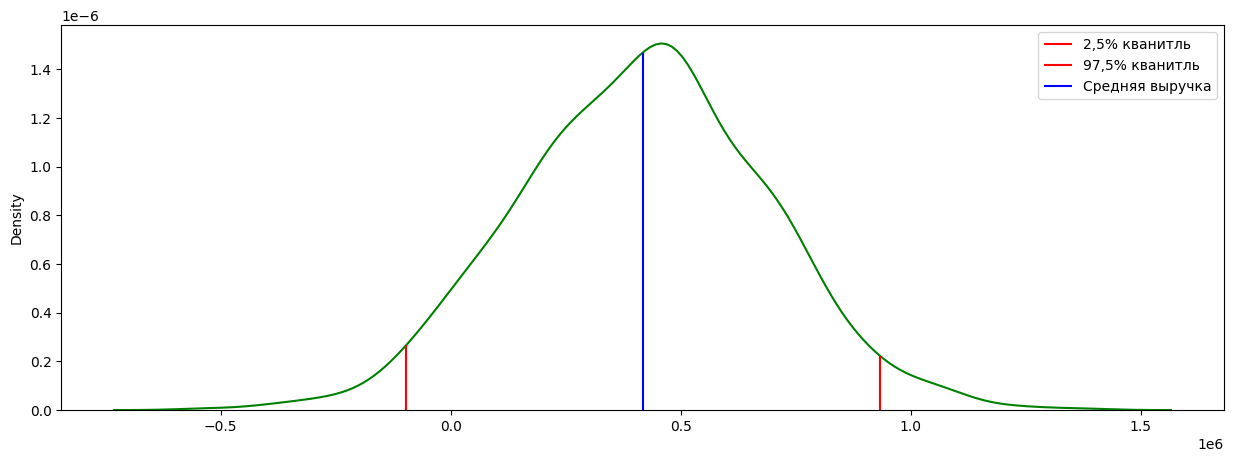

In [39]:
revenue_distr(region_01_results)

### регион 2

In [40]:
region_02_results = revenue_func(
    region_02, 'region_02', 'true_prod_02')
print(f'Средняя выручка: {region_02_results[0].mean():_.0f} тысяч рублей')
print(f'Доверитильный интервал 95%: ({region_02_results[1]:_.0f} , {region_02_results[2]:_.0f})')
print(f'Риск получить убытки: {len([x for x in region_02_results[0] if x < 0]) / len(region_02_results[0]):_.2%}')


Средняя выручка: 435_440 тысяч рублей
Доверитильный интервал 95%: (25_316 , 832_288)
Риск получить убытки: 1.90%


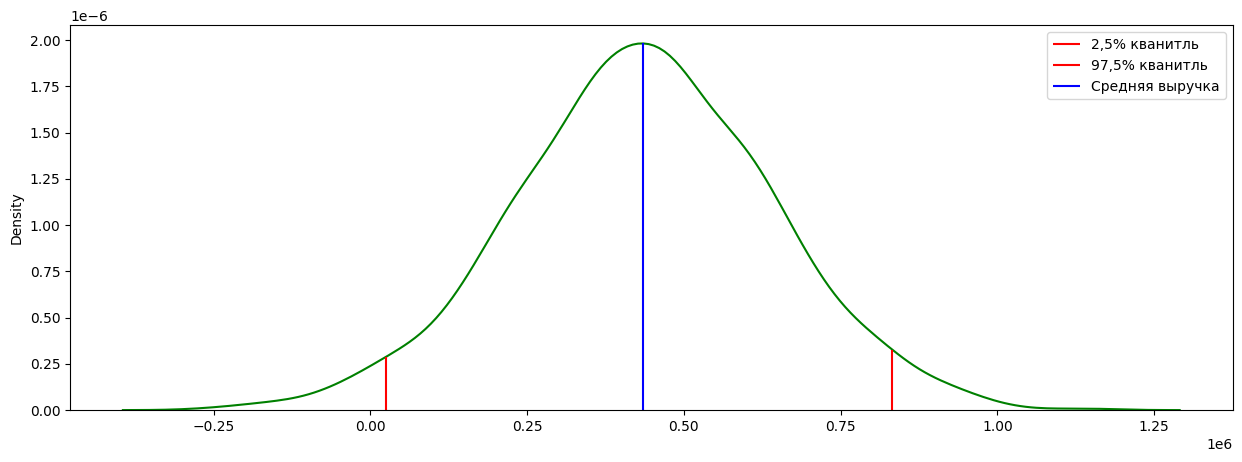

In [41]:
revenue_distr(region_02_results)

### регион 3

In [61]:
region_03_results = revenue_func(
    region_03, 'region_03', 'true_prod_03')
rev_3 = region_03_results[0].mean()
conf_int_3 = region_03_results[1] , region_03_results[2]
loss_3 = len([x for x in region_03_results[0] if x < 0]) / len(region_03_results[0])
print(f'Средняя выручка: {rev_3:_.0f} тысяч рублей')
print(f'Доверитильный интервал 95%: ({conf_int_3[0]:_.0f}, {conf_int_3[1]:_.0f})')
print(f'Риск получить убытки: {loss_3:_.1%}')


Средняя выручка: 372_530 тысяч рублей
Доверитильный интервал 95%: (-164_867, 920_722)
Риск получить убытки: 7.8%


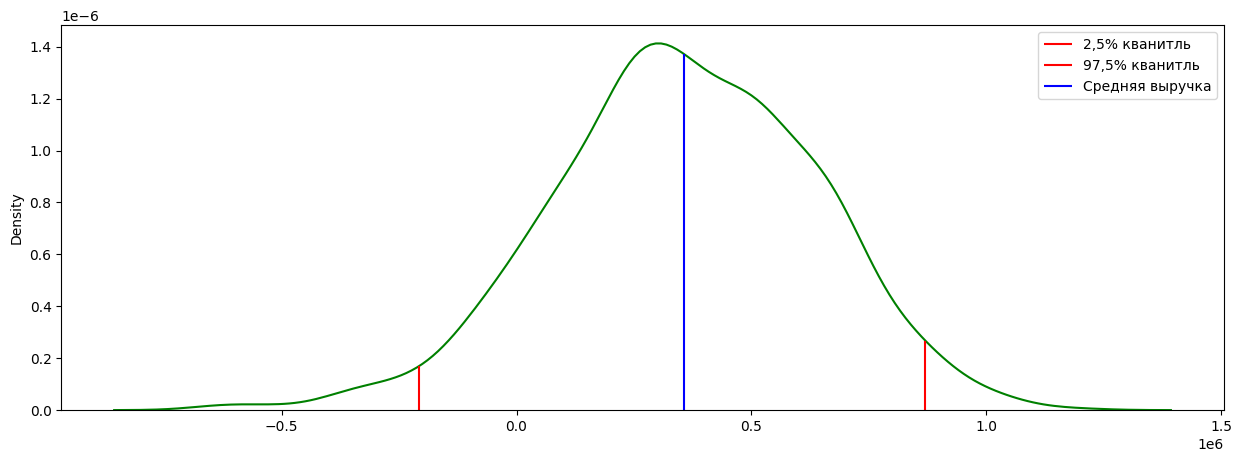

In [43]:
revenue_distr(region_03_results)

### Выводы. Рачет прибыли и рисков

1. Подготовлена функция расчета прибыли:
- отбор 500 скважин в регионе из общего объема предсказанных моделью 
- сортировка этих скважин по убыванию запасов
- отбор 200 лучших
- соотнесение индексов предсказанных 200 лучших с реальными запасами
- получаяем значение прибыли вычетанием себестоимости из реальных запасов 200 отобранных
2. Произведен расчет рисков: 
- получен массива из вариантов прибылей методом Бутстреп
- оценка риска убытков (отрицательной прибыли) по 2,5% квантилю массива
3. Произведена оценка прибыли регионов:

- регион 2 - самый перспективный к разработке
    - Средняя выручка: 436_202 тыс. рублей
    - Доверитильный интервал 95%: (33_685 , 832_305)
    - риск получить убытки 1.80%
    
- регион 1
    - Средняя выручка: 416_533 тыс.рублей
    - Доверитильный интервал 95%: (-116_474 , 872_514)
    - риск получить убытки 5.8%
- регион 3
    - Средняя выручка: 372_351 тыс.рублей
    - Доверитильный интервал 95%: (-207_717 , 898_399)
    - риск получить убытки loss_3 = {{loss_3}}

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован